# GDP spectral analysis

- [ ] velocity
- [ ] acceleration

Derivation of velocities and acceleration :
- ve, vn already computed via LOWESS METHOD
- vx, vy centered derivation using projection of lon, lat
- acc_x, acc_y double centered derivation using projection of lon, lat
- ae, an centered derivation of ve, vn£


In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import geopandas as gpd
#from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import drifters.utils as ut
import pynsitu as pin

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
from dask.distributed import Client

if True :
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=3, processes=3, walltime='04:00:00')
    w = cluster.scale(jobs=8)
    #from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    #w = cluster.scale(jobs=8) # 5 for gps, 8 for argos
else:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.40:8787/status,
Dashboard: http://10.148.0.40:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.40:35011,Workers: 0
Dashboard: http://10.148.0.40:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Load

In [3]:
# LOAD files with velocities and accelerations computed

#CHOOSE FILE 
amp_v = 1
amp_a = 1e-4

key = 'gps'
root_dir = "/home1/datawork/mdemol/GDP"
parquet = os.path.join(root_dir, key + "_av_time.parquet")

#parquet_argos_noise = os.path.join(root_dir, f"argos_av_noise_{amp_v}_{amp_a}.parquet")
#parquet_gps_noise = os.path.join(root_dir, f"gps_av_noise_{amp_v}_{amp_a}.parquet")

In [11]:


# drop all variables but relevant ones
col = ["id",'time',  "lon", "lat", "ve", "vn", 'ae', 'an', 'vex', 'vny', 'aex', 'any']
df = dd.read_parquet('parquet_' + key).reset_index()[col].persist()

In [12]:
df

,id,time,lon,lat,ve,vn,ae,an,vex,vny,aex,any
npartitions=160,,,,,,,,,,,,
,int64,datetime64[ns],float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


# Generate Spectra

In [13]:
df = df.rename(columns={'time': 'date'})

# add time in hours
time_unit = pd.Timedelta('1H')
t_ref = pd.Timestamp(2000,1,1)
df["time"] = (df["date"] - t_ref ) / time_unit

In [14]:
T_str = '60D' # days
dt = '1H' # sampling

N = int(pd.Timedelta(T_str)/pd.Timedelta(dt)) # output size
T = pd.Timedelta(T_str)/time_unit # must be in the same units than time

columns = ['lon', 'lat']
columns0 = columns + ['ve', 'vn']   
columns1 = columns + ['ae', 'an']   
columns2 = columns + ['vex', 'vny'] 
columns3 = columns + ['aex', 'any'] 

labels = ['ven', 'aen', 'vxy', 'axy']
Columns = {'ven':columns0, 'aen':columns1, 'vxy':columns2, 'axy':columns3 }


In [15]:
def process_uv(lon, lat, u, v, N, dt, **kwargs):
    ''' Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        u, v: pd.Series
            zonal, meridional index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    if lon is None:
        uv = None
    else:
        uv = u + 1j*v
    return pin.tseries.get_spectrum(uv, N, dt=dt, **kwargs)

In [16]:
df.head()

,id,date,lon,lat,ve,vn,ae,an,vex,vny,aex,any,time
0,22192,2001-07-01 02:00:00,-94.795609,5.53791,0.6460,-0.2900,-2.777825e-07,-3.472219e-07,0.649771,-0.761679,1.698938e-06,-3.157259e-06,13130.0
1,22192,2001-07-01 03:00:00,-94.774597,5.52852,0.6466,-0.2901,-2.777825e-07,-3.472219e-07,0.649771,-0.761679,1.698938e-06,-3.157259e-06,13131.0
2,22192,2001-07-01 04:00:00,-94.753387,5.51876,0.6440,-0.2925,-1.361113e-06,-1.180553e-06,0.656827,-0.785170,2.221023e-06,-5.036993e-06,13132.0
3,22192,2001-07-01 05:00:00,-94.731918,5.50841,0.6368,-0.2986,-2.000001e-06,-1.694444e-06,0.660713,-0.807147,-6.206238e-08,8.546555e-08,13133.0
4,22192,2001-07-01 06:00:00,-94.710457,5.49807,0.6296,-0.3047,-2.000001e-06,-1.694444e-06,0.660724,-0.806720,6.839744e-08,4.095455e-09,13134.0


### For ve, vn; ae, an; ux, uy; acc_x, acc_y

In [17]:
#pin.drifters.
dfg = df.groupby("id").get_group(22192).compute()# for GPS
#dfg = df.groupby("id").get_group(8707978).compute() #for ARGOS

out = pin.drifters.time_window_processing(dfg, process_uv, columns0, T, N, id_label='id', dt=dt, geo=True)
#dfg.set_index("time").plot(x="lon", y="lat")


Df_chunked = {}
for l in Columns : 
    df_chunked = (df
              .groupby("id")
              .apply(pin.drifters.time_window_processing,
                     process_uv,
                     Columns[l],
                     T,
                     N,
                     id_label='id',
                     dt=dt,
                     geo=True,
                     meta=out,
                    )
              .persist()
             )
    # recompute date
    df_chunked["date"] = t_ref + df_chunked.index*time_unit
    # rename x/y
    df_chunked = df_chunked.rename(columns=dict(x="lon", y="lat"))
    
    Df_chunked[l] = df_chunked
    

In [19]:
Df_chunked['aen'].tail()

,lon,lat,id,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,-0.15,-0.13333333333333333,-0.11666666666666667,-0.1,-0.08333333333333333,-0.06666666666666667,-0.05,-0.03333333333333333,-0.016666666666666666,date
173844.0,-154.771713,-13.547626,67206560.0,4.946831e-13,1.168325e-12,3.833478e-12,1.927337e-12,3.314480e-13,2.468237e-12,6.507575e-12,...,9.881997e-13,3.194039e-13,1.653219e-12,1.840566e-12,3.513395e-13,6.696660e-13,4.012743e-13,5.306978e-13,3.881488e-13,2019-10-31 12:00:00
174564.0,-156.086831,-15.336086,67206560.0,3.051758e-13,1.871567e-13,2.781979e-13,5.788202e-13,4.753738e-12,8.686184e-12,1.307618e-12,...,1.296730e-11,1.772796e-11,1.136284e-12,7.286593e-12,3.939218e-12,2.762646e-13,5.167371e-13,2.930615e-12,1.665246e-12,2019-11-30 12:00:00
175284.0,-158.549145,-18.326836,67206560.0,6.618814e-14,5.199336e-13,1.225549e-12,5.039774e-13,7.824482e-12,1.521763e-11,8.912937e-12,...,1.444319e-12,1.417153e-12,1.570994e-12,9.169575e-12,9.527796e-12,6.849681e-12,4.405938e-12,1.005019e-12,1.737477e-13,2019-12-30 12:00:00
176004.0,-161.003404,-20.412056,67206560.0,2.436677e-14,6.051766e-13,3.176449e-12,2.140129e-12,1.893553e-12,4.921755e-12,4.176360e-12,...,7.363489e-12,2.030155e-12,2.011291e-12,4.650578e-13,3.250893e-13,2.935872e-13,6.842024e-13,1.390341e-12,2.440291e-13,2020-01-29 12:00:00
176724.0,-162.291692,-22.641391,67206560.0,9.526379e-13,6.413325e-13,4.060677e-12,6.869587e-12,3.799906e-12,1.024786e-11,4.929460e-12,...,1.532764e-12,1.490494e-12,2.593122e-13,4.766892e-12,1.913903e-12,4.683954e-13,9.382613e-13,4.524020e-12,2.799874e-12,2020-02-28 12:00:00


In [ ]:
# store
#ut.store_diag()
#df_chunked = df_chunked.repartition(partition_size="100MB")
#df_chunked.to_parquet(..., mode="w")

---

# Bin geographically

https://github.com/apatlpo/mit_equinox/blob/master/parcels/spectra_binned.ipynb

In [21]:
# bin geographically
dl = 2.
lon_bins = np.arange(-180.,180.+dl, dl)#CAUTION : add dl to upper bound (prevent from pb with last binning intervals)
lat_bins = np.arange(-90, 90+dl, dl)

### For ve, vn; ae, an; ux, uy; acc_x, acc_y

In [22]:
DF = Df_chunked
DF_geo = {}
Ds = {}
for l in DF :
    DF[l]['lon'] = (DF[l]['lon']+180)%360 - 180
    DF[l]['lon_cut'] = DF[l]['lon'].map_partitions(pd.cut, bins=lon_bins)
    DF[l]['lat_cut'] = DF[l]['lat'].map_partitions(pd.cut, bins=lat_bins)
    DF_geo[l] = DF[l].groupby(['lon_cut', 'lat_cut']).mean().compute()

    #Converting pandas dataframe in xarray dataset:
    index = pd.MultiIndex.from_arrays([DF_geo[l].index.map(lambda v: v[0].mid),
                                       DF_geo[l].index.map(lambda v: v[1].mid)
                                      ], 
                                      names=('lon_cut', 'lat_cut'),
                                     )
    ds = (pd.melt(DF_geo[l].set_index(index)
                  .drop(columns=['id', 'lon','lat'])
                  .reset_index(), id_vars=['lon_cut', 'lat_cut',],
                  var_name='frequency',
                 )
          .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E_'+l})
         ).to_xarray().set_index(index=['lon_bins', 'lat_bins','frequency']).unstack()
    ds['frequency'] = ds['frequency'].astype(float)
    ds = ds.sortby('frequency')
    #ds = ds.chunk({'frequency': 100})
    Ds[l]=ds
    print(l)

ven
aen
vxy
axy


In [23]:
ds = xr.merge(list(Ds.values()))

#set attrs
ds.E_ven.attrs={'long_name':"Power density spectra v = ve + jvn", 'units':r'$m^2/s^2/cpd$'}
ds.E_vxy.attrs={'long_name':"Power density spectra v = vx + jvy", 'units':r'$m^2/s^2/cpd$'}
ds.E_axy.attrs={'long_name':"Power density spectra a = ax + jay", 'units':r'$m^2/s^4/cpd$'}
ds.E_aen.attrs={'long_name':"Power density spectra a = ae + jan", 'units':r'$m^2/s^4/cpd$'}
ds.frequency.attrs={'long_name':"frequency", 'units':'cpd'}

In [26]:
ds

<xarray.Dataset>
Dimensions:    (lon_bins: 180, lat_bins: 90, frequency: 1440)
Coordinates:
  * lon_bins   (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * lat_bins   (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
Data variables:
    E_ven      (lon_bins, lat_bins, frequency) float64 nan nan nan ... nan nan
    E_aen      (lon_bins, lat_bins, frequency) float64 nan nan nan ... nan nan
    E_vxy      (lon_bins, lat_bins, frequency) float64 nan nan nan ... nan nan
    E_axy      (lon_bins, lat_bins, frequency) float64 nan nan nan ... nan nan
    E_venw2    (lon_bins, lat_bins, frequency) float64 nan nan nan ... nan nan
    E_vxyw2    (lon_bins, lat_bins, frequency) float64 nan nan nan ... nan nan

In [25]:
ds['E_venw2']=ds['E_ven']*(ds['frequency']*2*np.pi/3600/24)**2
ds['E_vxyw2']=ds['E_vxy']*(ds['frequency']*2*np.pi/3600/24)**2

_________
# Store spectra

In [12]:
root_dir = "/home1/datawork/mdemol/GDP"
zarr_argos = os.path.join(root_dir, "argos_spectra.zarr")
zarr_gps = os.path.join(root_dir, "gps_spectra.zarr")
#zarr_argos_noise = os.path.join(root_dir, f"argos_spectra_noise_{amp_v}_{amp_a}.zarr")
#zarr_gps_noise = os.path.join(root_dir, f"gps_spectra_noise_{amp_v}_{amp_a}.zarr")

In [13]:
ds.to_zarr(zarr_argos, mode="w") 

In [14]:
ds_reload = xr.open_zarr(zarr_argos).persist()
ds_reload

<xarray.Dataset>
Dimensions:    (lon_bins: 179, lat_bins: 89, frequency: 1440)
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0
  * lon_bins   (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
Data variables:
    E_aen      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_axy      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_ven      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxy      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>

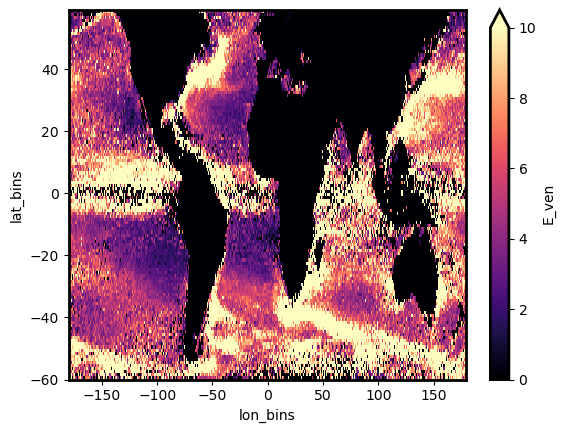

In [16]:
ds_reload.E_ven.sum("frequency").plot(x="lon_bins", cmap='magma', vmax=10)

In [5]:
cluster.close()